# Final Project - Parallel Programming
This notebook is written on **Google Colab**. If the contents are not displayed correctly, or for the most up-to-date version of this notebook, please visit this link

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1wwVhTOZJBHU4jqrja_VQiYp21y_44jaB)

**Parallel Programming - 19KHMT - HCMUS**

**Final Project:**

Parallelize and optimize an application.


**Group information**

No. | Student ID | Student name           | Notes
----|------------|------------------------|-------
1   | 19127277   | Võ Xuân Thiên          |
2   | 19127292   | Nguyễn Thanh Tình      | Leader
3   | 19127496   | Trương Quang Minh Nhật |

**Table of contents**
1. Application description
2. Sequential implementation
3. Parallel implementation
4. Parallel optimization
5. Reflection
6. References

# 1. Application description

**Seam carving**

According to [Wikipedia](https://en.wikipedia.org/wiki/Seam_carving), **Seam carving** (or **liquid rescaling**) is an algorithm for content-aware image resizing by establishing a number of seams (paths of least importance) in an image and automatically removes seams to reduce image size or inserts seams to extend it.

Method         | Describe                     | Image
---------------|------------------------------|------
Original Image | Image to be made narrower    | ![img](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Broadway_tower_edit.jpg/274px-Broadway_tower_edit.jpg)
Scaling        | The image is distorted       | ![img](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Broadway_tower_edit_scale.png/186px-Broadway_tower_edit_scale.png)
Cropping       | Part of the image is removed | ![img](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Broadway_tower_edit_cropped.png/186px-Broadway_tower_edit_cropped.png)
Seam carving   | No distorting                | ![img](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Broadway_tower_edit_Seam_Carving.png/186px-Broadway_tower_edit_Seam_Carving.png)

*(Source: https://en.wikipedia.org/wiki/Seam_carving)*

**Input:** an RGB image.

**Output:** the resized image without distorting important objects.

**Use case:** displaying images without distortion on media of various sizes (cellphones, websites, projection screens).

**Does it need to speed up?:**
- Yes, it’s really slow!
- The complexity of the subtasks in the Seam Carving algorithm are all $O(n^2)$, which costs a lot of processing time.
- If the processing is slow, we will not be able to resize the image quickly and meet the tasks that need it quickly such as photo editing, displaying content on devices, etc.

# 2. Sequential implementation

## 2.1. Design

*Before we start*
- A **"seam"** is a set of pixels and each pairs of adjacent pixels are connected together.
- A seam can be either vertical or horizontal. A vertical seam is a path of pixels connected from top to bottom in an image with one pixel in each row. A horizontal seam is similar with the exception of the connection being from left to right.
- The **"red line"** in the image below represents for a **vertical seam**.
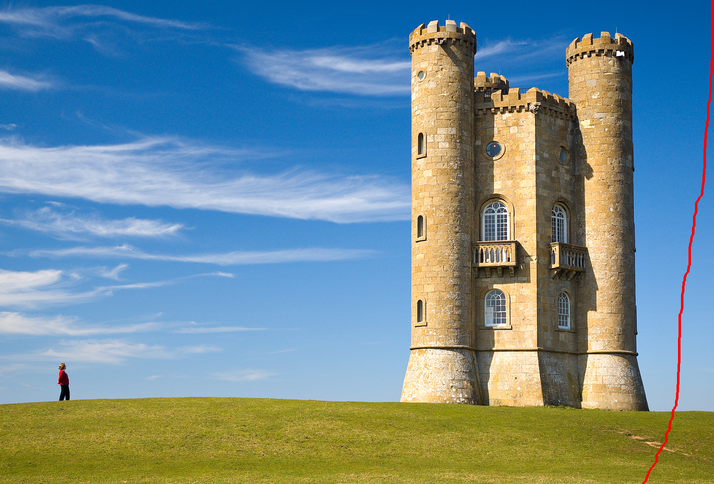

*From Input to Output*
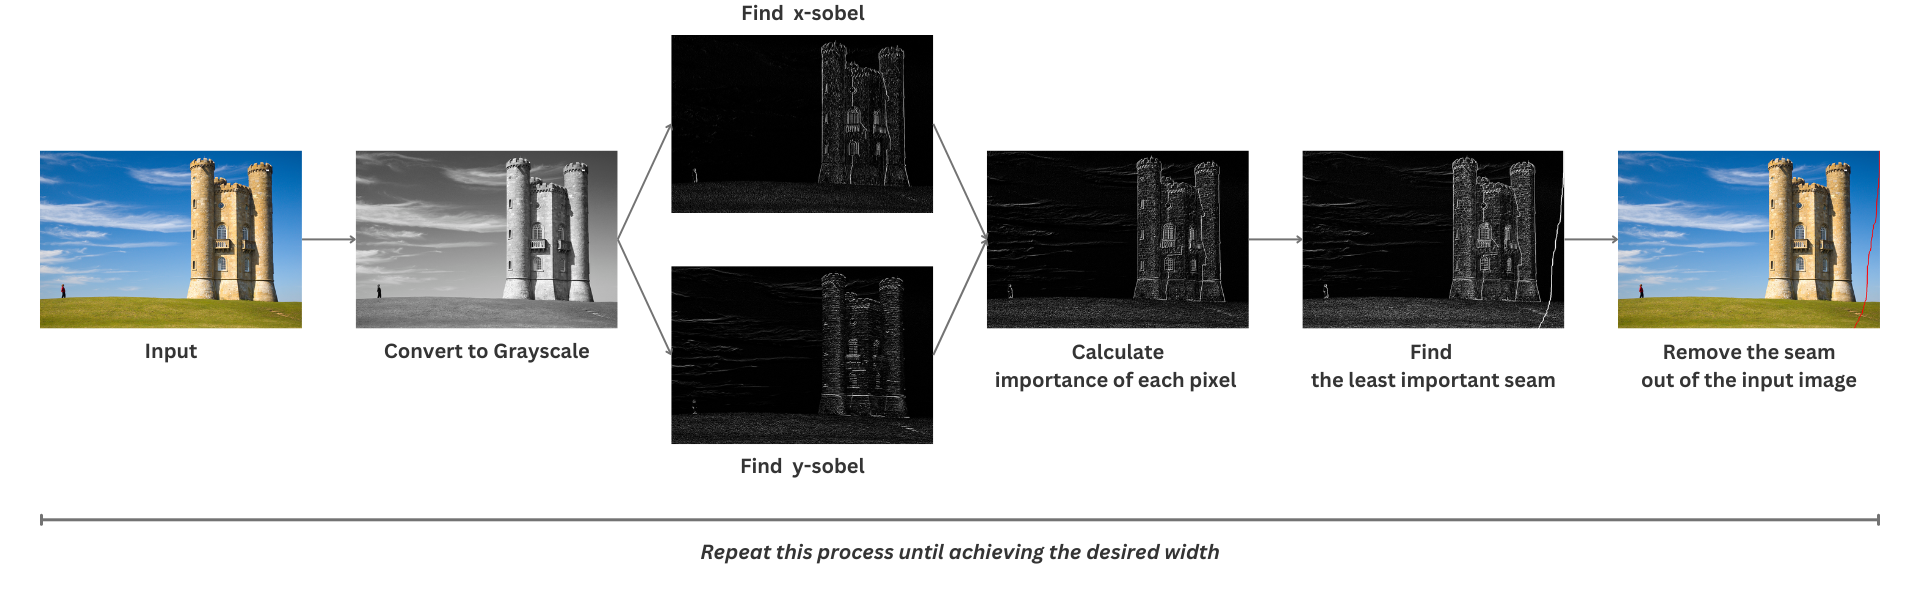

*Step 1. Convert image to Grayscale*

For a beautiful and clearly result image, follow this math equation:
$$Grayscale=0.299∗Red+0.587∗Green+0.114∗Blue$$

*Step 2. Find x-sobel and y-sobel*

Detect edges in the x-direction by convolution of the
grayscale image with x-Sobel filter as follow:
$$
\left[\begin{array}{cc}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{array}\right]
$$

Detect edges in the y-direction by convolution of the
grayscale image with y-Sobel filter as follow:
$$
\left[\begin{array}{cc}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{array}\right]
$$

*Step 3. Calculate importance of each pixel*
$$importance = |sobel_x| + |sobel_y|$$

*Step 4. Finding the least importance seam*

There are many methods to find the least importance seam, such as: Dijkstra's algorithm, greedy algorithm, dynamic programming, etc. Let's dig in **Dynamic Programming**.

Let $L[i, j]$ be the value of seam with the smallest value starting from the bottom and ending at coordinates $[i, j]$.

Assuming $i$ runs from $height-2$ to $0$, and $j$ runs from $0$ to $width-1$, the value of $L[i]$ will be calculated from $L[i+1]$ which is calculated before. There are three ways to get to $[i, j]$, which are from $[i+1, j-1]$, $[i+1, j]$ and $[i+1, j+1]$, so the smallest seam is the seam has the smallest value from these three ways.

The recursive formula would be:
$$
\left\{\begin{array}\
L[i, j] = importance[i, j] & i=height-1, & ∀j ∈ [0, width - 1]\\
L[i, j] = importance[i, j] + min(L[i+1, j-1], L[i+1, j], L[i+1, j+1]) & ∀i ∈ [height - 2, 0], & ∀j ∈ [0, width - 1]\\
\end{array}\right.
$$

If the parameter inside the $min()$ function is not valid, it will not considered.

The smallest seam will have the smallest value equal to the smallest element on $L[0]$.

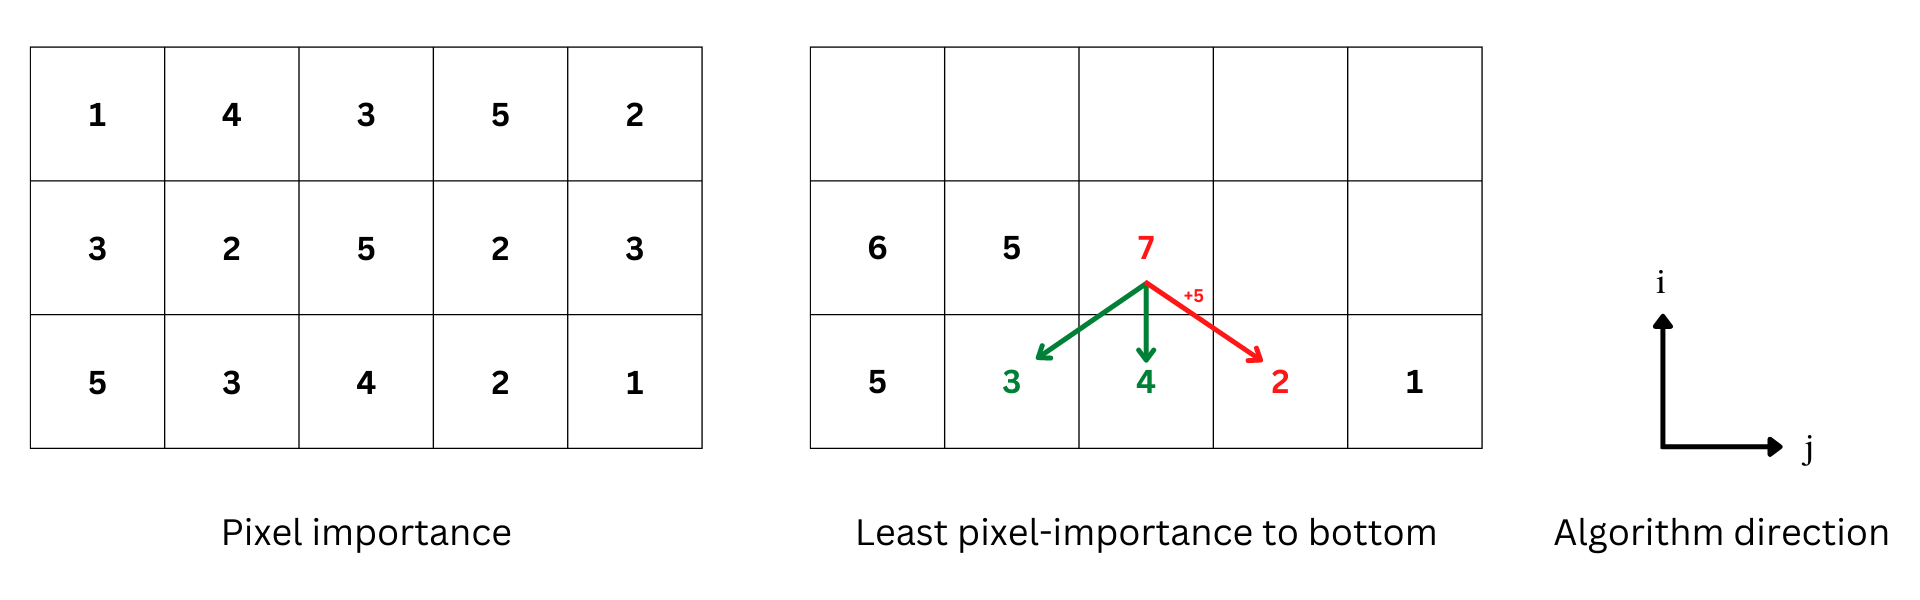

*Step 5. Trace back and remove the seam out of the input image*

At the construction step of the array $L$, each time assign $L[i, j] = importance[i, j] + min(L[i+1, j-1], L[i+1, j], L[i+1, j+1])$, it should be noted that to get that minimum value, $L[i, j]$ was calculated from which cell, and the result will be stored in $T[i, j]$ as below:
- `-1`: calculated from $L[i+1, j-1]$
- `0` : calculated from $L[i+1, j]$
- `1` : calculated from $L[i+1, j+1]$

After calculating the array $L$, the array $T$ has also been built. Specially, the last row is also the beginning row, so the value can be assigned to default value $0$.

To conduct the tracing, after finding the smallest element on $L[0]$, it is easy to know where this cell is built from thanks to the array T, namely the cell $[1, j_{min} + T[0, j_{min}]$. Repeat this process until the last row.

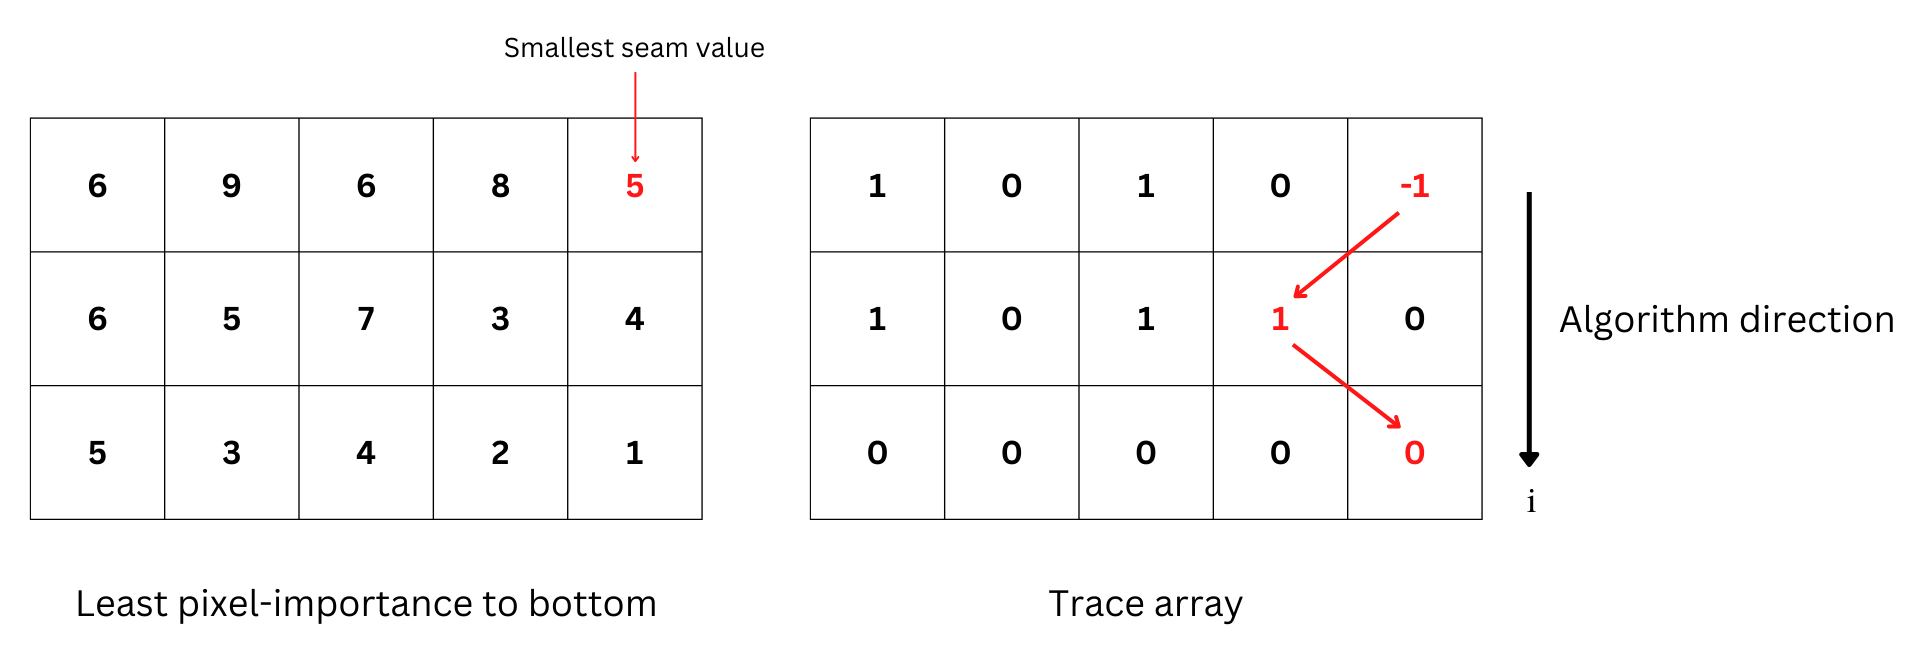

*Enlarge image*

The easiest way to enlarge a image is **duplicating all the pixels on the least importance seam by averaging them with their left and right neighbors, and repeating this process until achiving the target width**. But this way is most likely stretching artifact by choosing the same seam.

So, the improve enlarge process, the program will process on the first $k$ seam. But it should be noted that **duplicating all the seams in an image is equivalent to standard scaling**. The best way to enlarge image is **breaking the process into several steps, and each step does not enlarge the size of the image in more than a fraction of its size from the previous step (for instance, greater than 50%)**.

Here are the specific steps of the algorithm:
- Step 1. Calculate $k$:
$$k=min(TargetWidth-Width, Width / 2)$$
- Step 2. Find the first $k$ least importance seams for removal.
- Step 3. Duplicate all pixels on those seams by averaging them with their left and right neighbors.
- Step 4. If $Width \neq TargetWidth$, back to Step 1, otherwise finish the algorithm.

## 2.2. Evaluate

*Experiment setup*

The below code is a Python code to automatically take 2 numbers corresponding to the GPU's compute capability and save them into 2 variables `major` and `minor`.

In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


Use NVCC Compiler of NVIDIA for compiling.

In [ ]:
!nvcc -arch=sm_{major}{minor} sequential.cu -o sequential

*Run the code to see results*

Reduce an image

In [ ]:
!./sequential in.pnm out.pnm 300

Input image size (width x height): 571 x 387

Processing time: 6753.933105 ms

Output image size (width x height): 300 x 387



Show input and output images

In [ ]:
import cv2
import matplotlib.pyplot as plt


def display_images(filenames, width, height):
    fig, axs = plt.subplots(1, len(filenames), figsize=(width, height))

    for i in range(len(filenames)):
        img = cv2.imread(filenames[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axs[i].imshow(img)
        axs[i].set_title(filenames[i])

    fig.tight_layout()

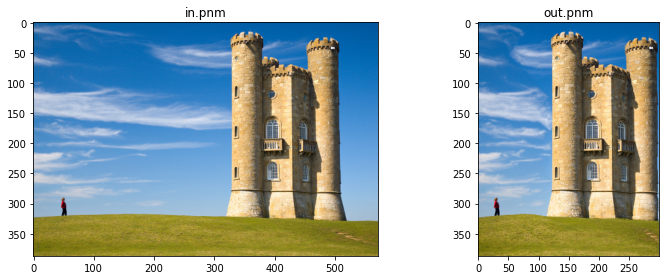

In [ ]:
display_images(['in.pnm', 'out.pnm'], 11, 4)

Enlarge an image

In [ ]:
!./sequential in.pnm out.pnm 800

Input image size (width x height): 571 x 387

Processing time: 8341.384766 ms

Output image size (width x height): 800 x 387



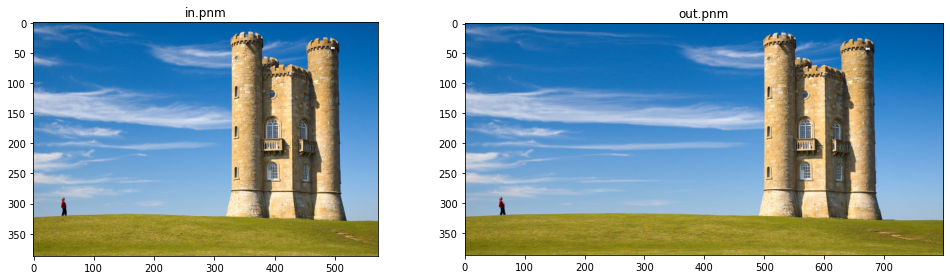

In [ ]:
display_images(['in.pnm', 'out.pnm'], 14, 4)

*Comments*
- The program run **correctly**.
- The resized image with smaller width is not distorted important objects: the woman, the castle, etc.
- The resized image with large width is **great**, which does not look like scaling, and **no glitch**.

# 3. Parallel implementation

## 3.1. Analyze

To implement an parallel version, we parallelize these steps:
- **Convert RGB to Gray**
- **Apply Filter (x-sobel and y-sobel)**
- **Calculate Importance**
- **Calculate Least Pixel Importance At Each Row and Trace array**
- **Remove seam**
- **Duplicate seam**

## 3.2. Design

**Convert RGB to Gray**
- Let each thread compute one element in the input/output matrix.
- Each thread calculate average with weight of 3 channels in the input matrix, then assign the result to the corresponding element in output matrix.

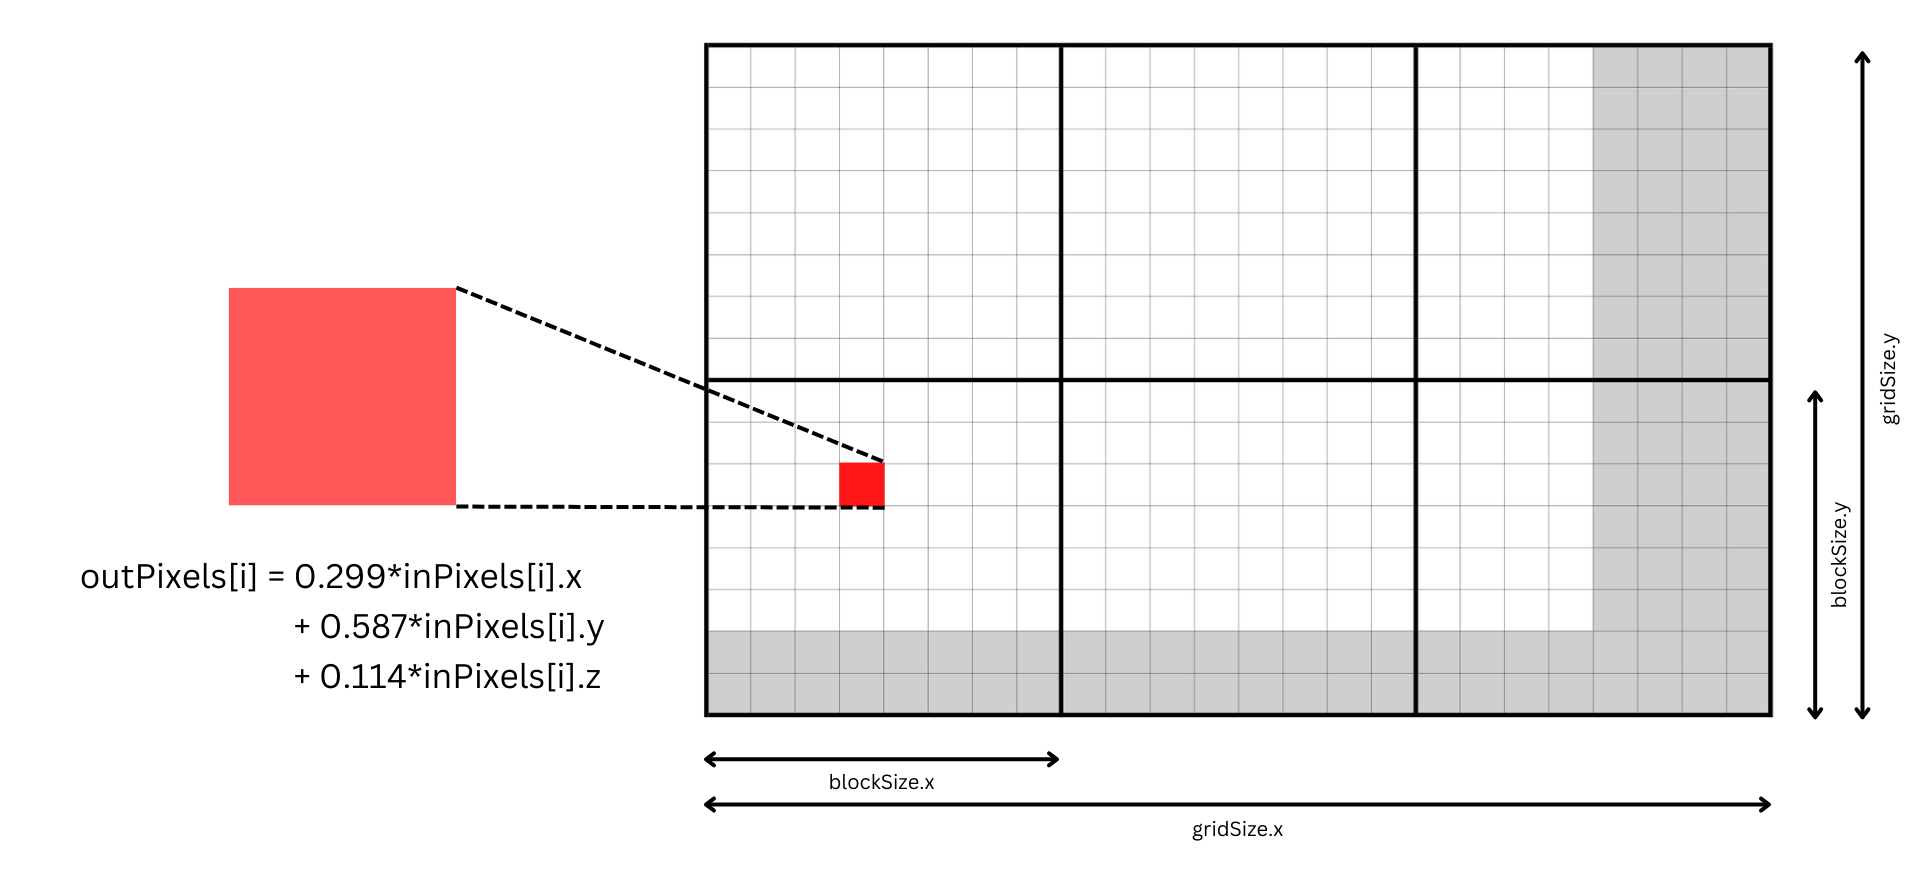

**Apply Filter (x-sobel or y-sobel)**
- Let each thread compute one element in the input/output matrix.
- Each thread do convolution operator on each pixel and their 8 neighbor pixels by applying `xSobel` or `ySobel` filter, then store the value in the corresponding element in out matrix.

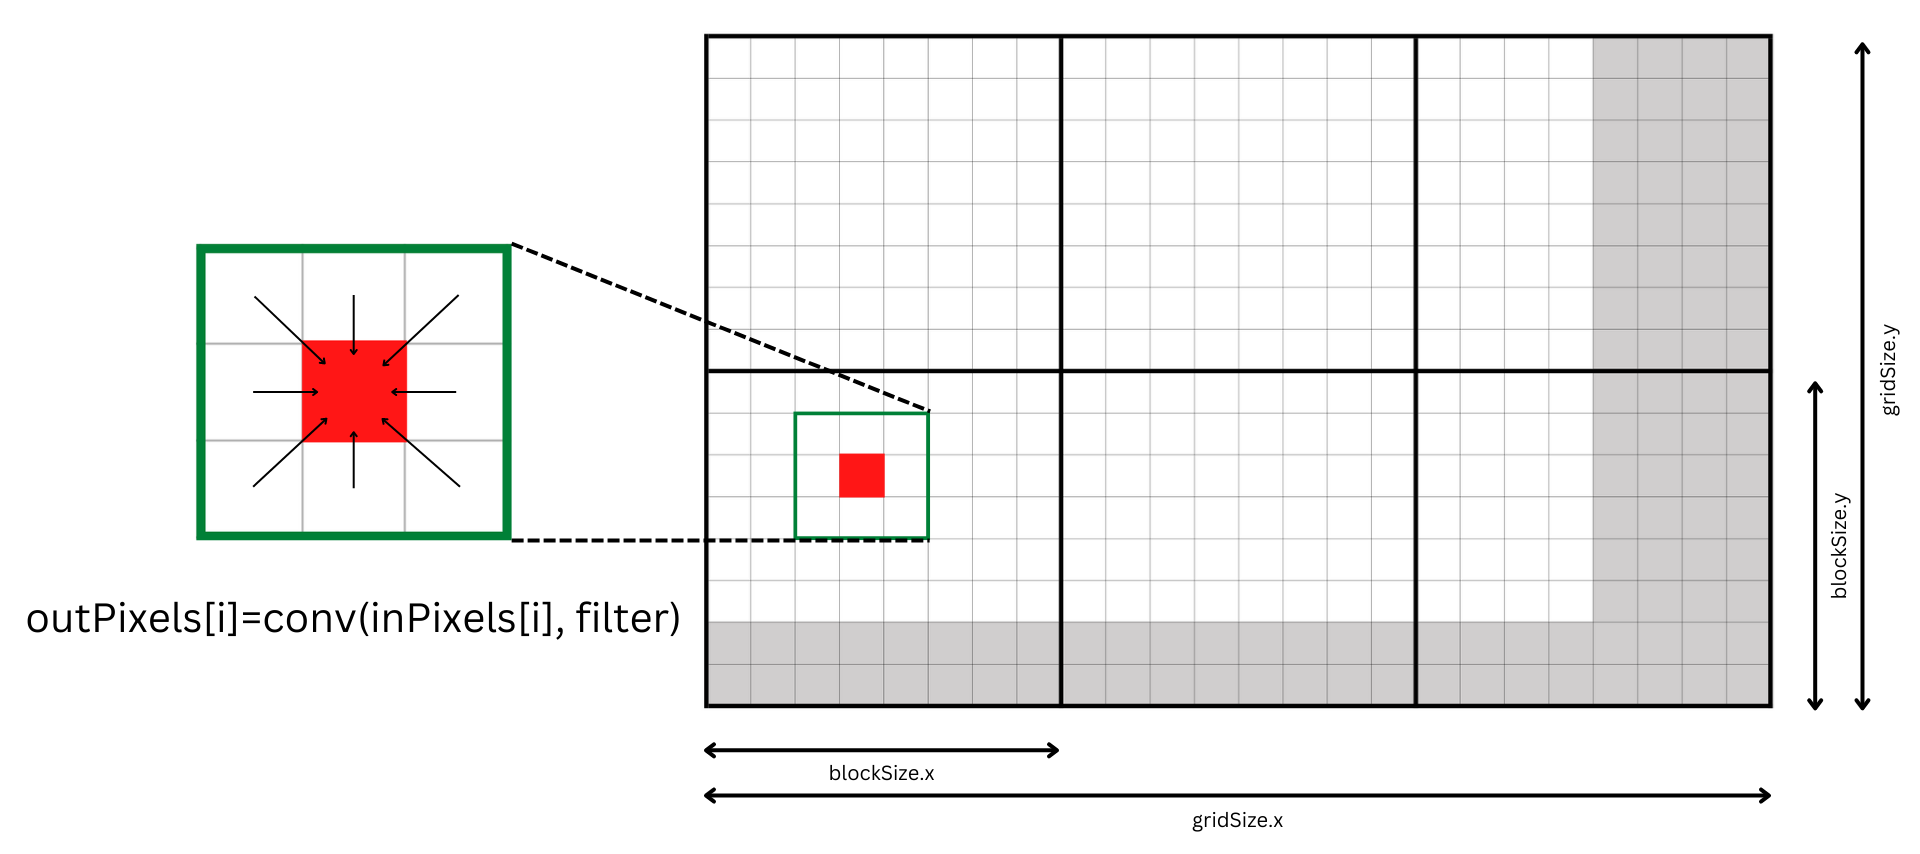

**Calculate Importance**
- Let each thread compute one element in the important matrix.
- Each thread is the value of addition between the correspoding element of `xSobel` and `ySobel` matrix.

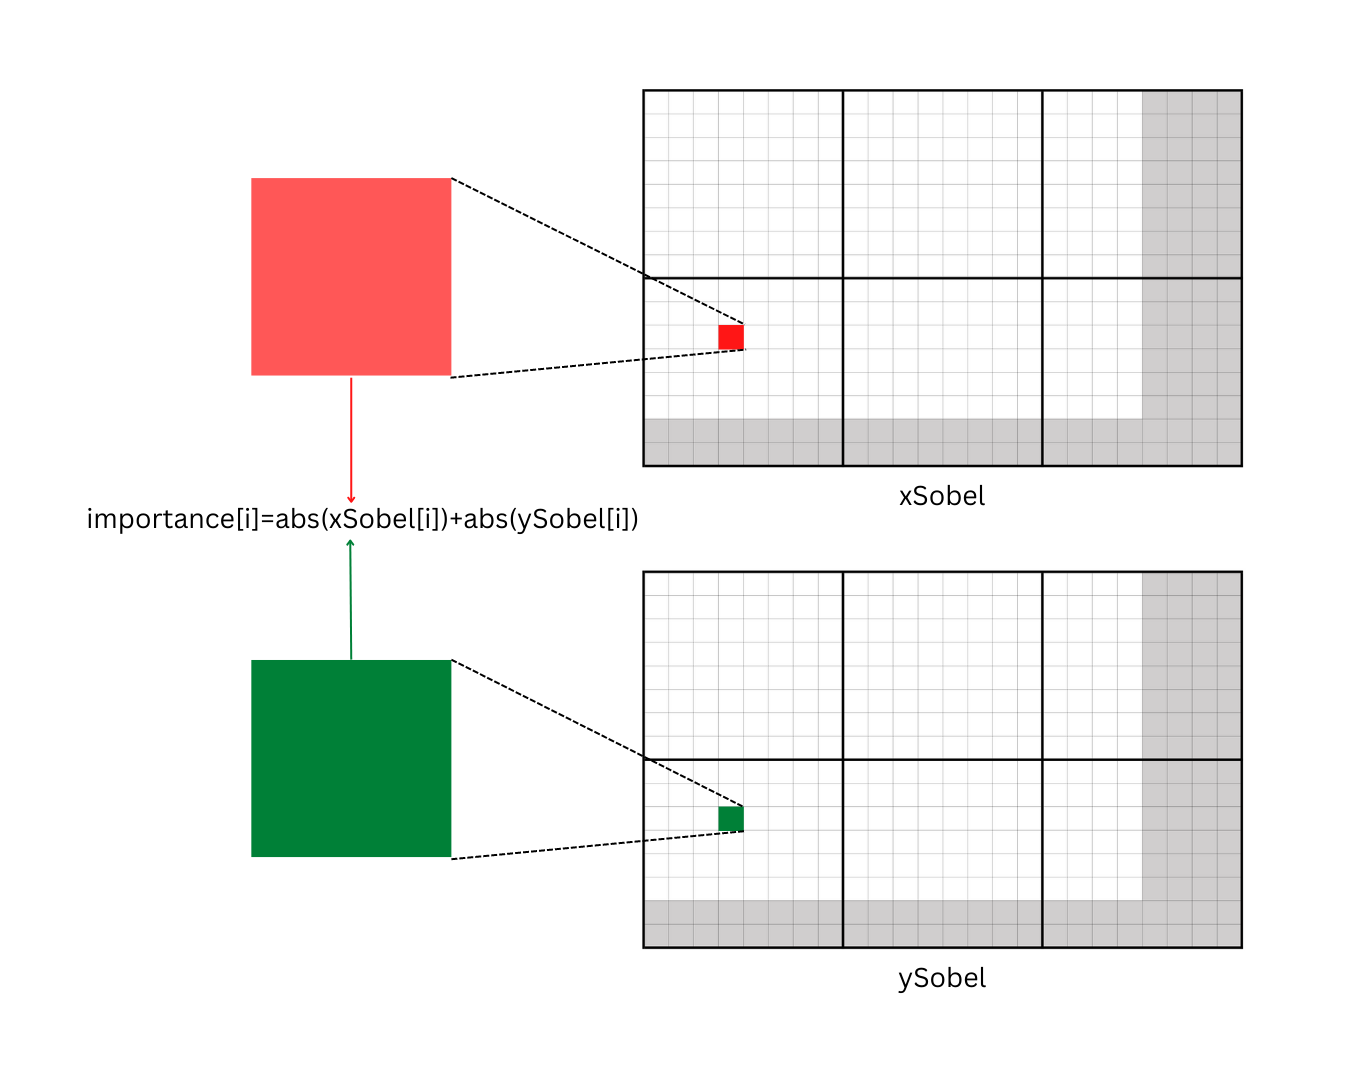

**Calculate Least Pixel Importance To Bottom and Trace array**

- Let each thread compute one element on a row of the matrix.
- To calculate least pixel importance to bottom of each element, it will consider 3 cells below that element to find out which cell has the smallest value.
- After that, it will add that least pixel important value to the important value of the element which handled by each thread.
- It is necessary to store the trace values while constructing the Least Pixel Importance to Bottom matrix. Each thread will assign an index (-1, 0, 1) to the cell which has the smallest important value in order to trace back the matrix and find the seam.

*Note*

In this method, before calculating least pixel important value of a cell in a row, we have to calculate the least pixel important value of the below cell of that row, so we can't calculate parallel on all of rows at the same time but we can calculate parallelly least pixel important value of each cell in a row, so flatten the blocksize from two dimensions to one dimension to have more processing units.

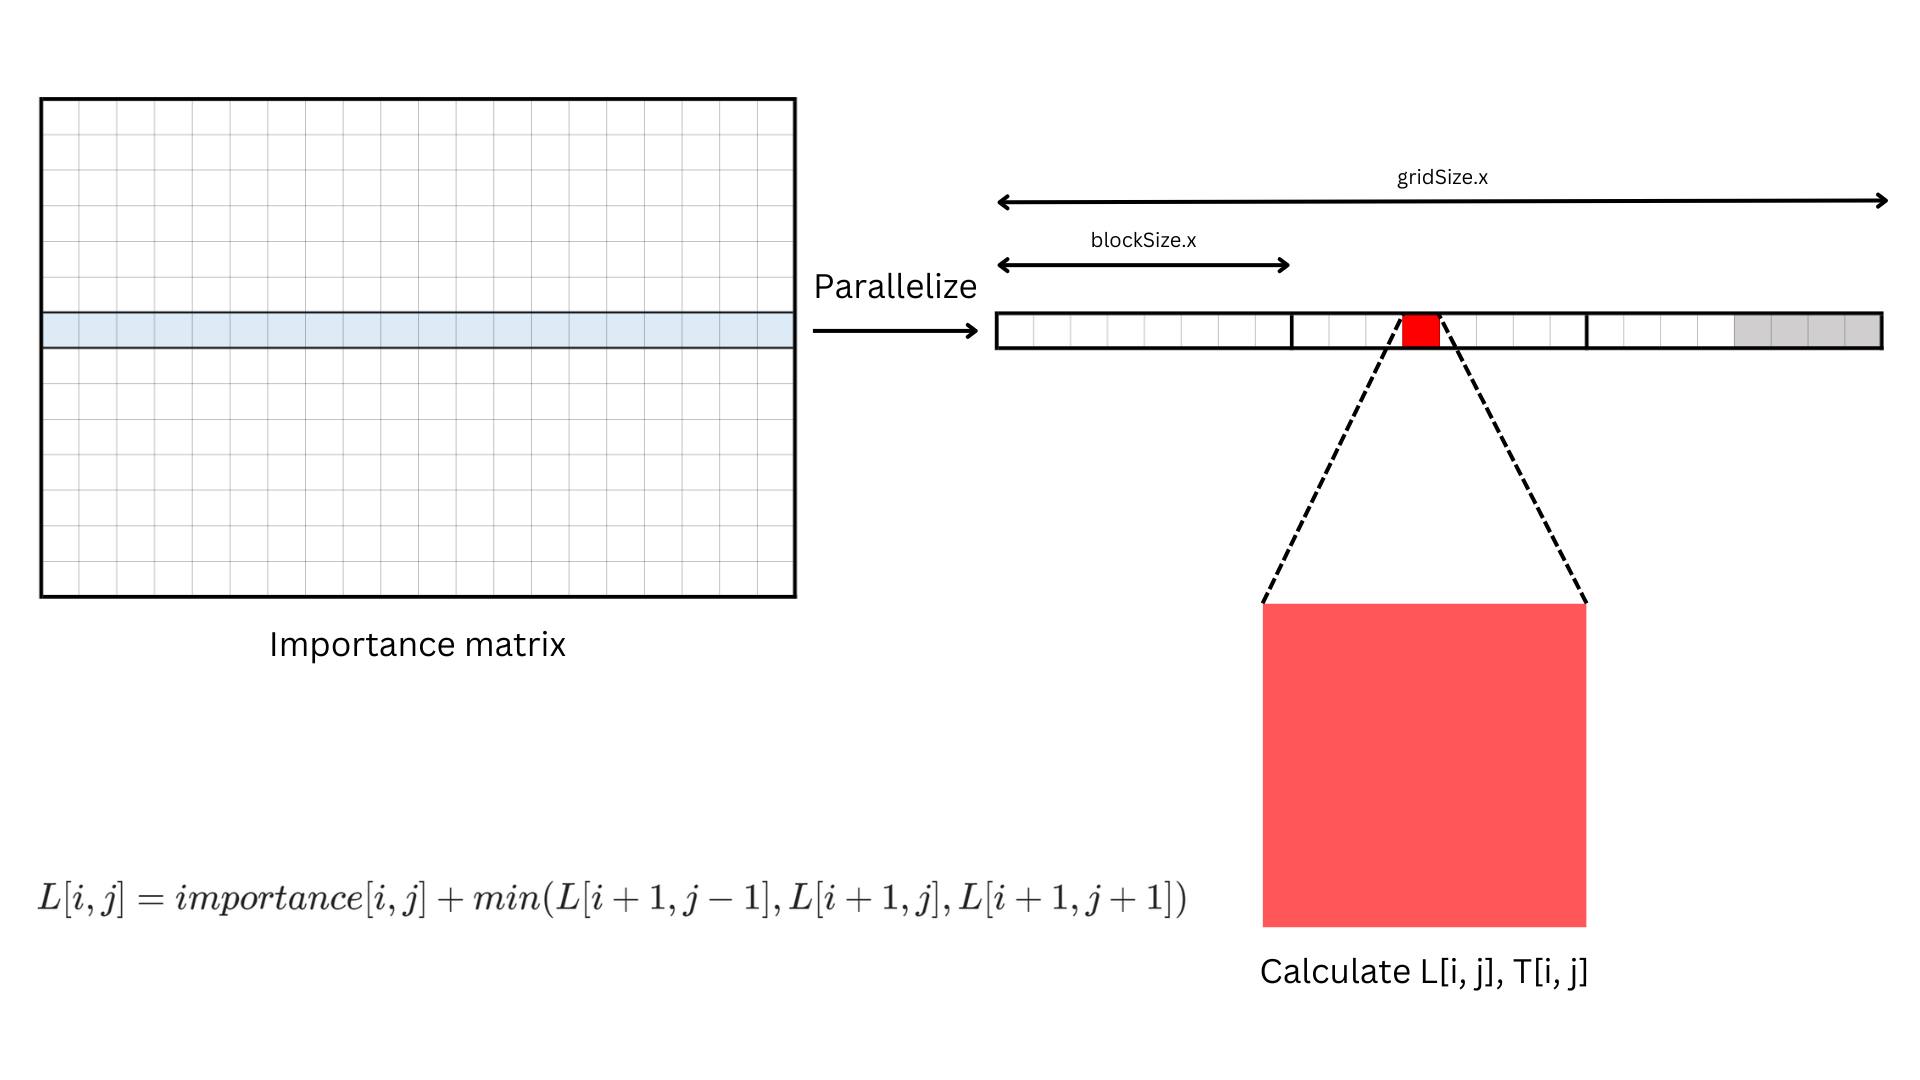

**Remove seam**
- Let each thread compute one element in the input matrix.
- If that element is at the left side of the seam, just keep the coresponding index in the output matrix.
- If that element is at the right side of the seam, it will assign to the previous index in the output matrix.

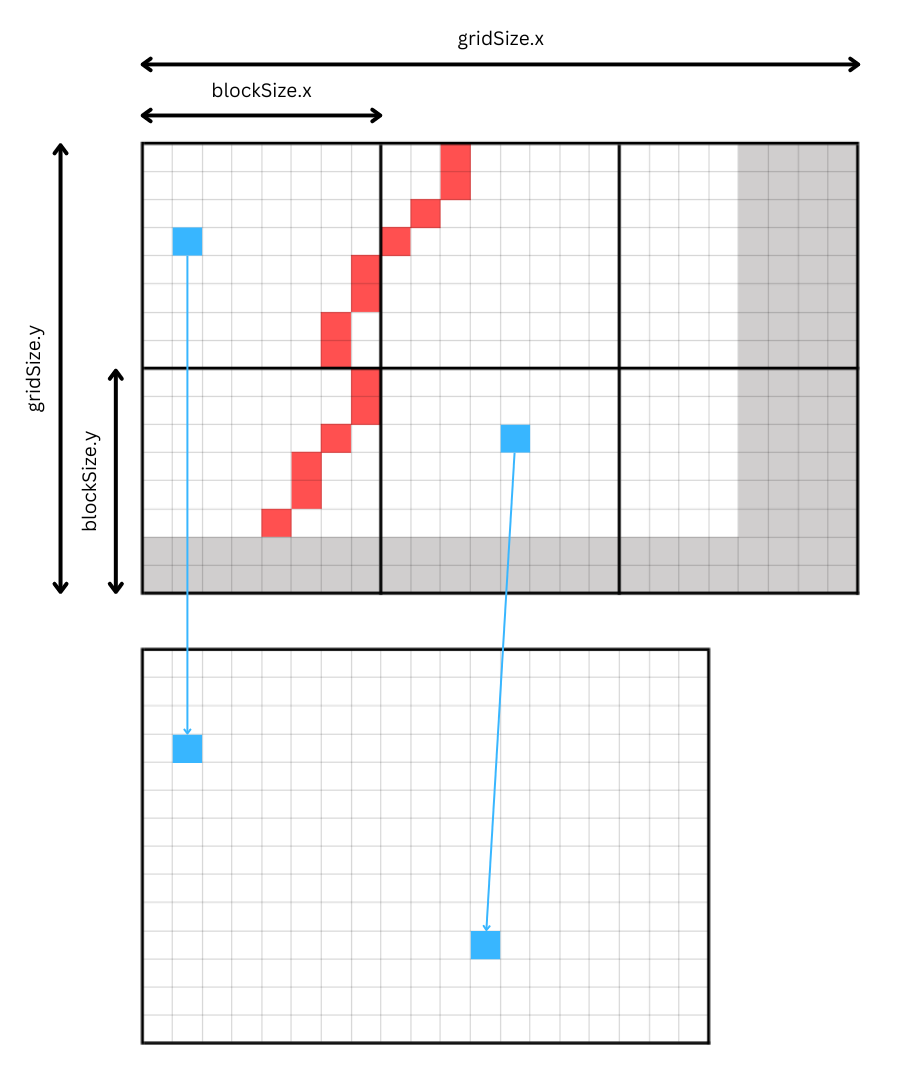

**Duplicate Seam**
- Let each thread compute one element in the input matrix.
- If that element is at the left side of the seam, just keep the coresponding index in the output matrix.
- If that element is at the right side of the seam, it will assign to the next index in the output matrix.
- If that element reach the pixel of the seam, it will duplicate that element pixel by the average with left and right pixels.

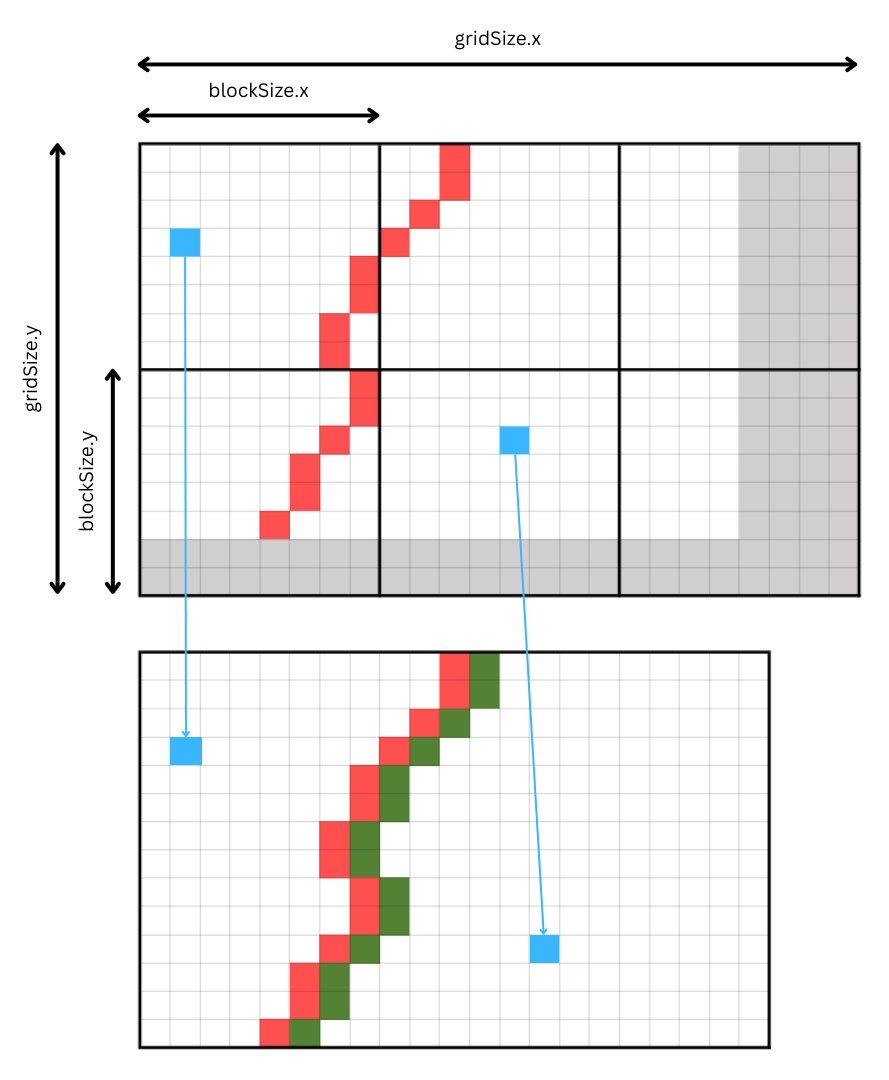

## 3.3. Evaluate

*Experiment setup*

Use NVCC Compiler of NVIDIA for compiling.

In [ ]:
!nvcc -arch=sm_{major}{minor} parallel.cu -o parallel

*Run the code to see results*

Reduce an image

In [ ]:
!./parallel in.pnm out.pnm 300

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1543.394531 ms

Output image size (width x height): 300 x 387



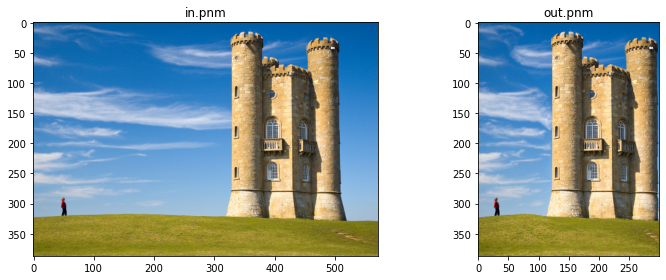

In [ ]:
display_images(['in.pnm', 'out.pnm'], 11, 4)

Enlarge an image

In [ ]:
!./parallel in.pnm out.pnm 800

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1286.189941 ms

Output image size (width x height): 800 x 387



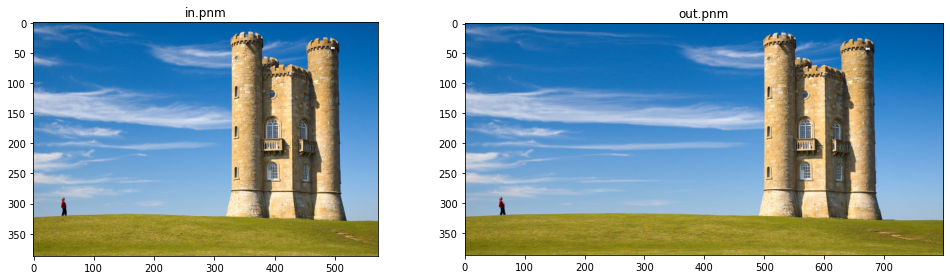

In [ ]:
display_images(['in.pnm', 'out.pnm'], 14, 4)

*Comments*

- The program run **correctly**.
- The resized image with smaller width is not distorted important objects: the woman, the castle, etc.
- The resized image with large width is **great**, which does not look like scaling, and **no glitch**.
- **RUN REALLY FASTER** than sequential version.

# 4. Parallel optimization

## 4.1. Optimization 1

### 4.1.1. Analyze

- Sobel filters are accessed multiple times on GMEM!

    ⇨ Sobel filters optimization.

- The `applyFilter` function does not manage memory efficiently.

    ⇨ Apply filter kernel optimization.

### 4.1.2. Design

**Sobel filter optimization**
- Instead of using **GMEM** for filter, we use **CMEM** for faster performance.
- We convert the declaration of filter from `__device__` to `__constant__`.

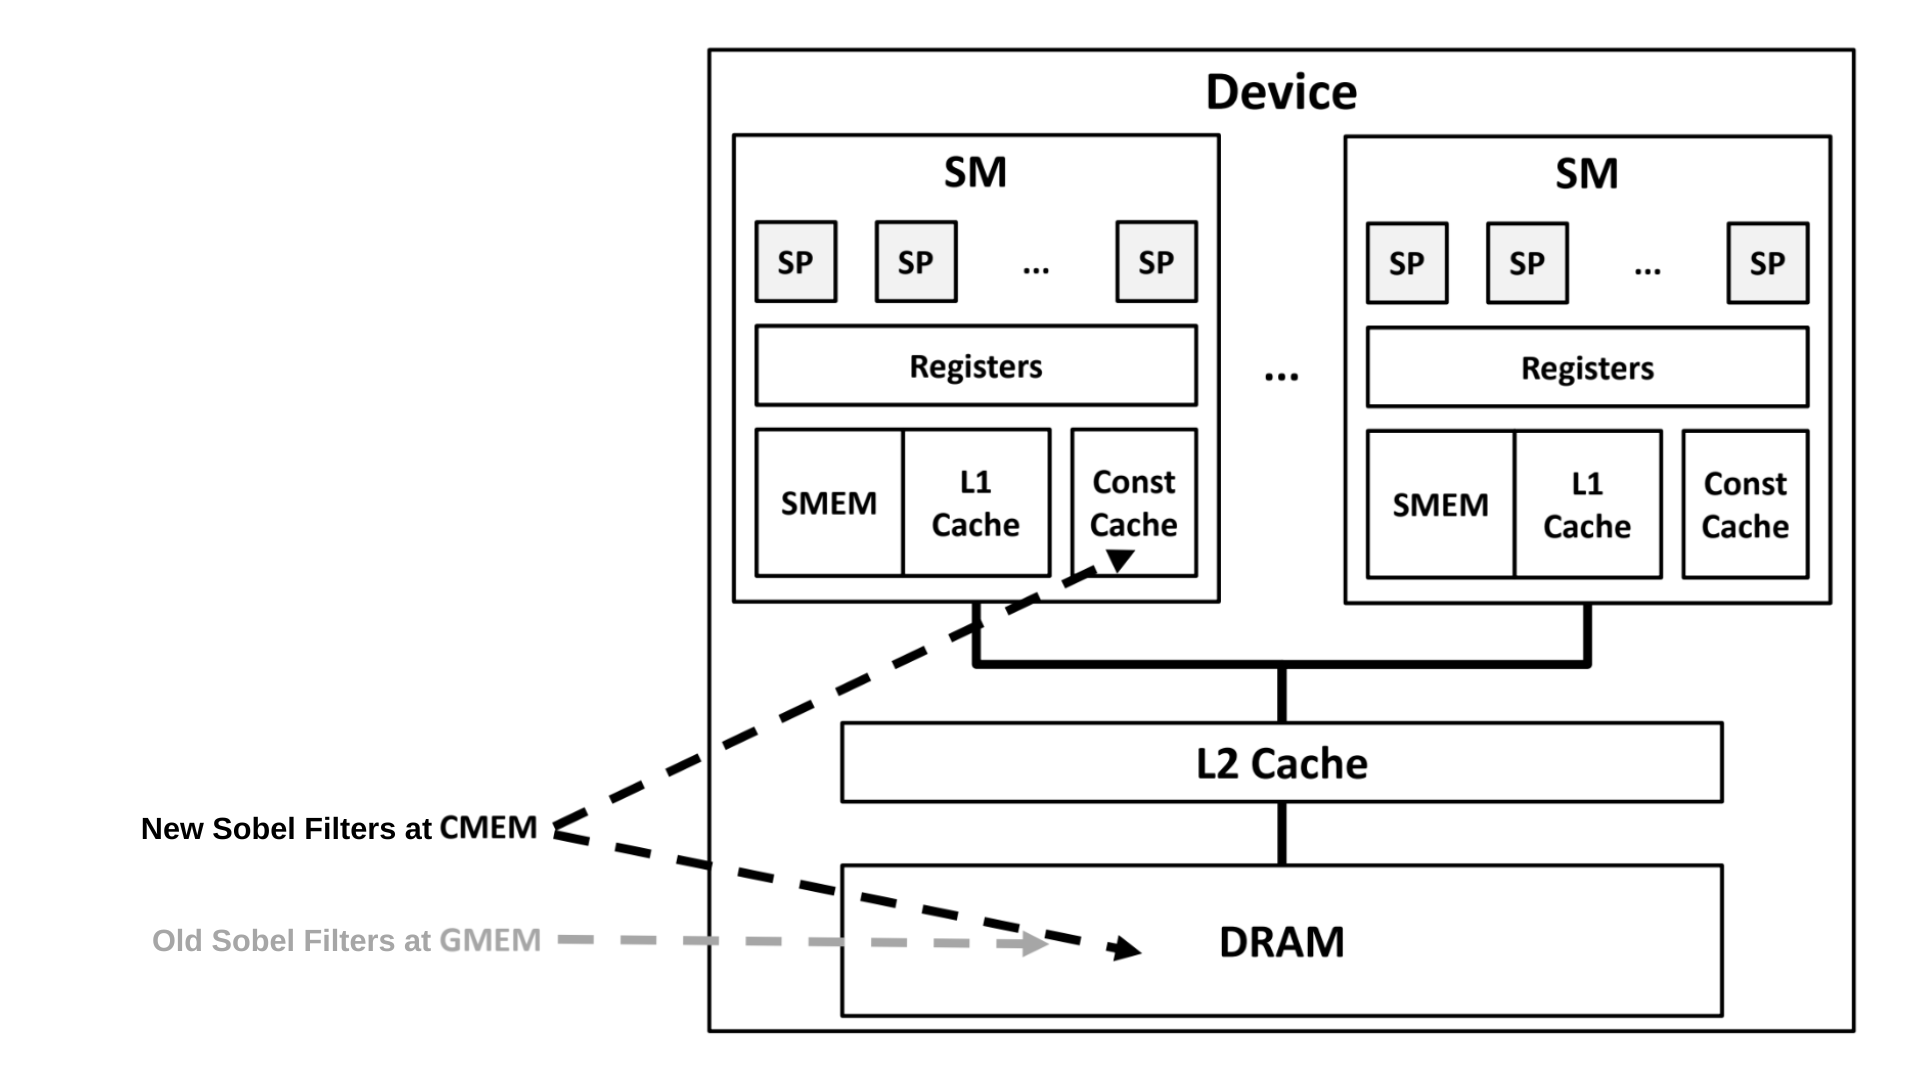

**Apply filter kernel optimization**
- In the `applyFilterKernel()` method, `outPixels[i]` (in **GMEM**) has been accessed total **10 times** which makes the program very slow. So, we declare a variable in **RMEM** to hold the value of `outPixels[i]` and after the for loop of convolution, its value is reassigned to the `outPixels[i]`.

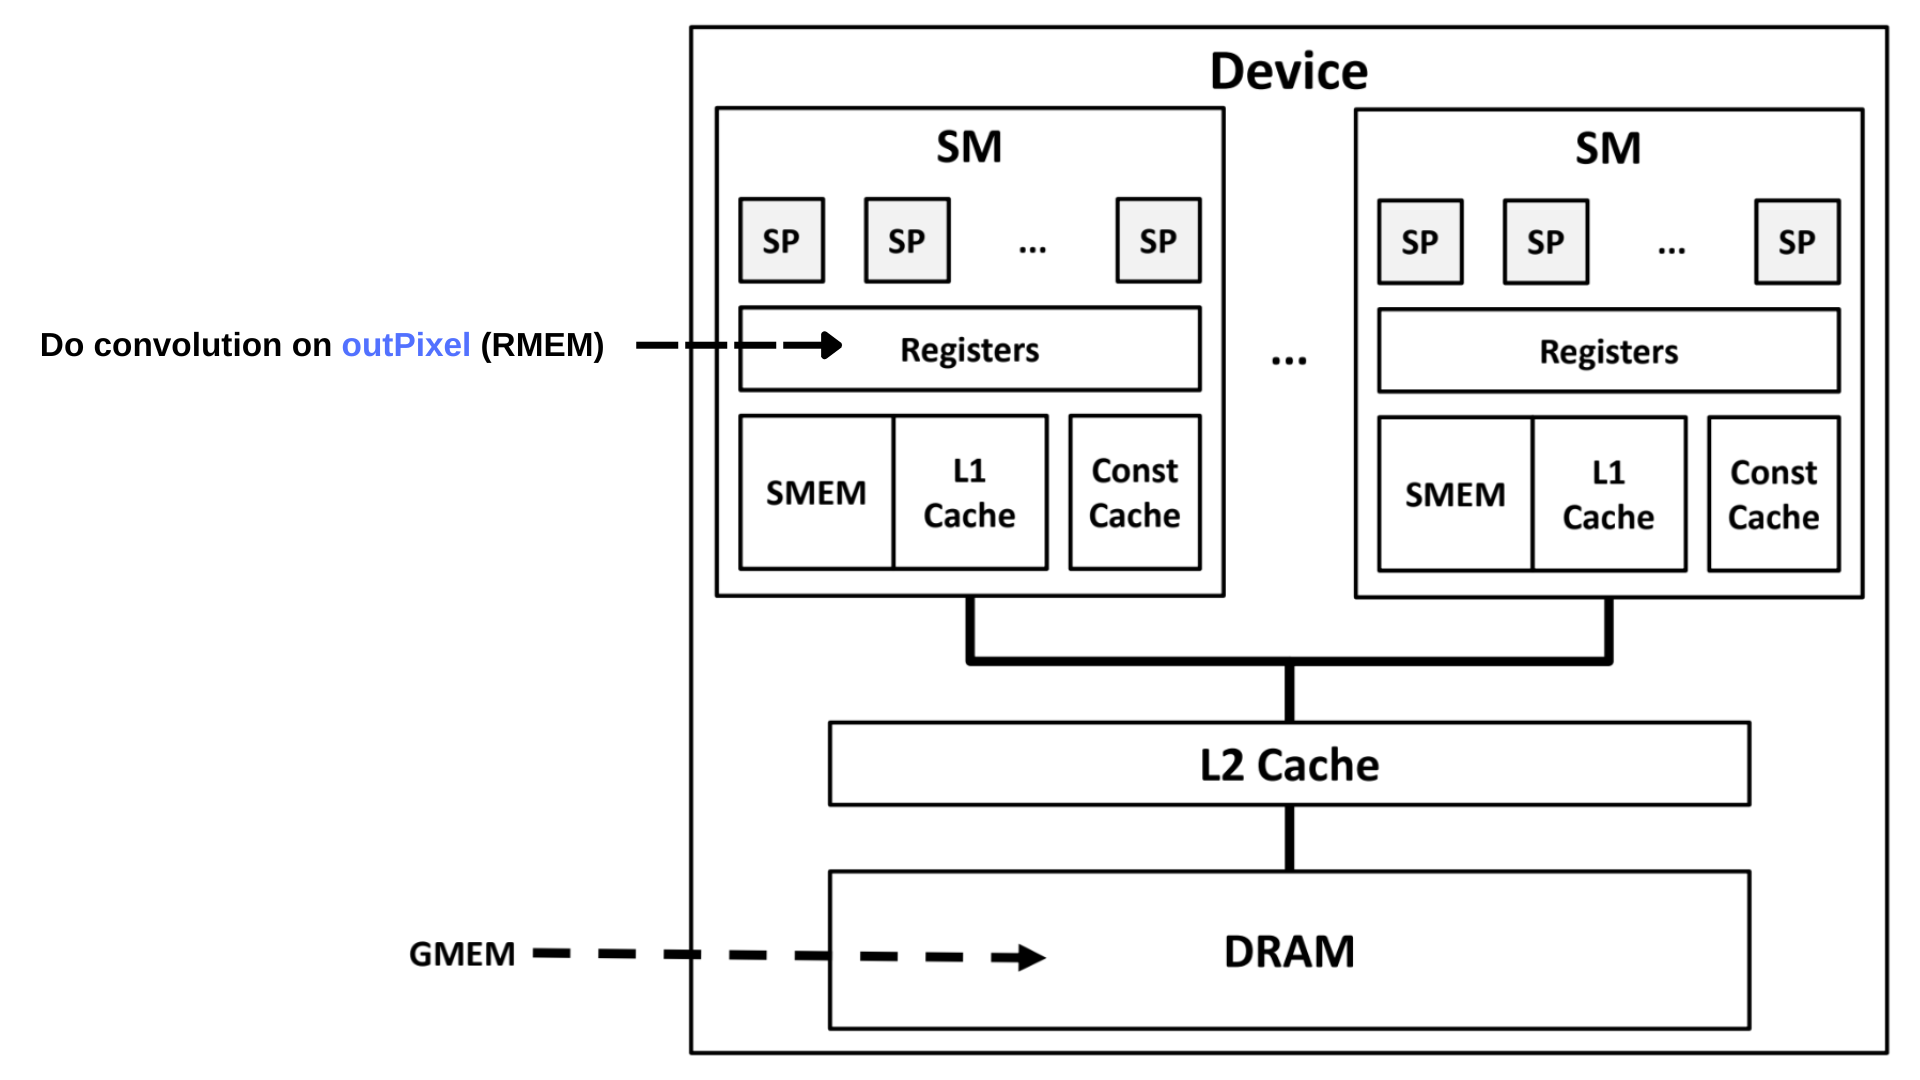

### 4.1.3. Evaluate

*Experiment setup*

Use NVCC Compiler of NVIDIA for compiling.

In [ ]:
!nvcc -arch=sm_{major}{minor} optimize_1.cu -o optimize_1

*Run the code to see results*

Reduce an image

In [ ]:
!./optimize_1 in.pnm out.pnm 300

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1517.210571 ms

Output image size (width x height): 300 x 387



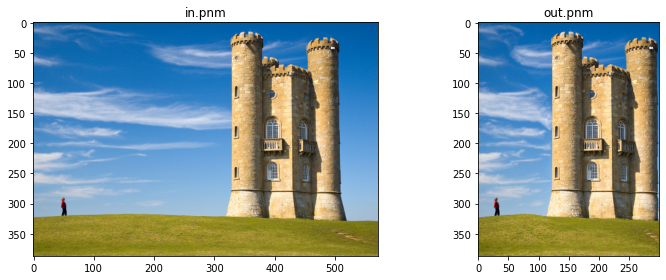

In [ ]:
display_images(['in.pnm', 'out.pnm'], 11, 4)

Enlarge an image

In [ ]:
!./optimize_1 in.pnm out.pnm 800

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1260.875610 ms

Output image size (width x height): 800 x 387



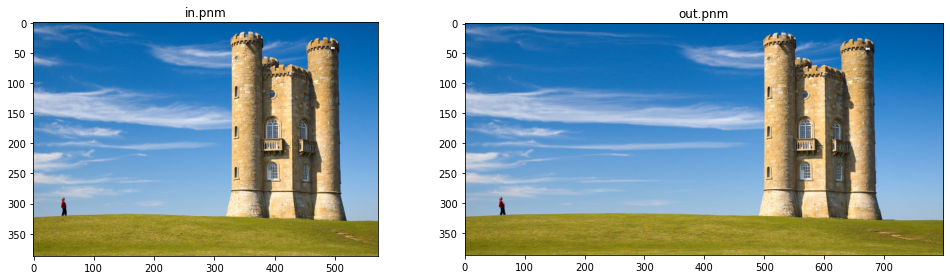

In [ ]:
display_images(['in.pnm', 'out.pnm'], 14, 4)

- The program run **correctly**.
- In all running cells, the procesing time of optimize version always smaller than the procesing time of parallel version, thereby the optimization is successful.
- But the processing time has not been significantly improved, the reason is that these optimizations are still simple. Let's come up with a more optimized but also more complex: optimize version 2.

## 4.2. Optimization 2

### 4.2.1. Analyze

Threads in the same block access the same element many times, and those elements are located on the GMEM, making the program run slower.

⇨ Apply Filter Optimization.

### 4.2.2. Design

For minimizing GMEM usage caused by many threads accessing to the same element, we use SMEM memory.

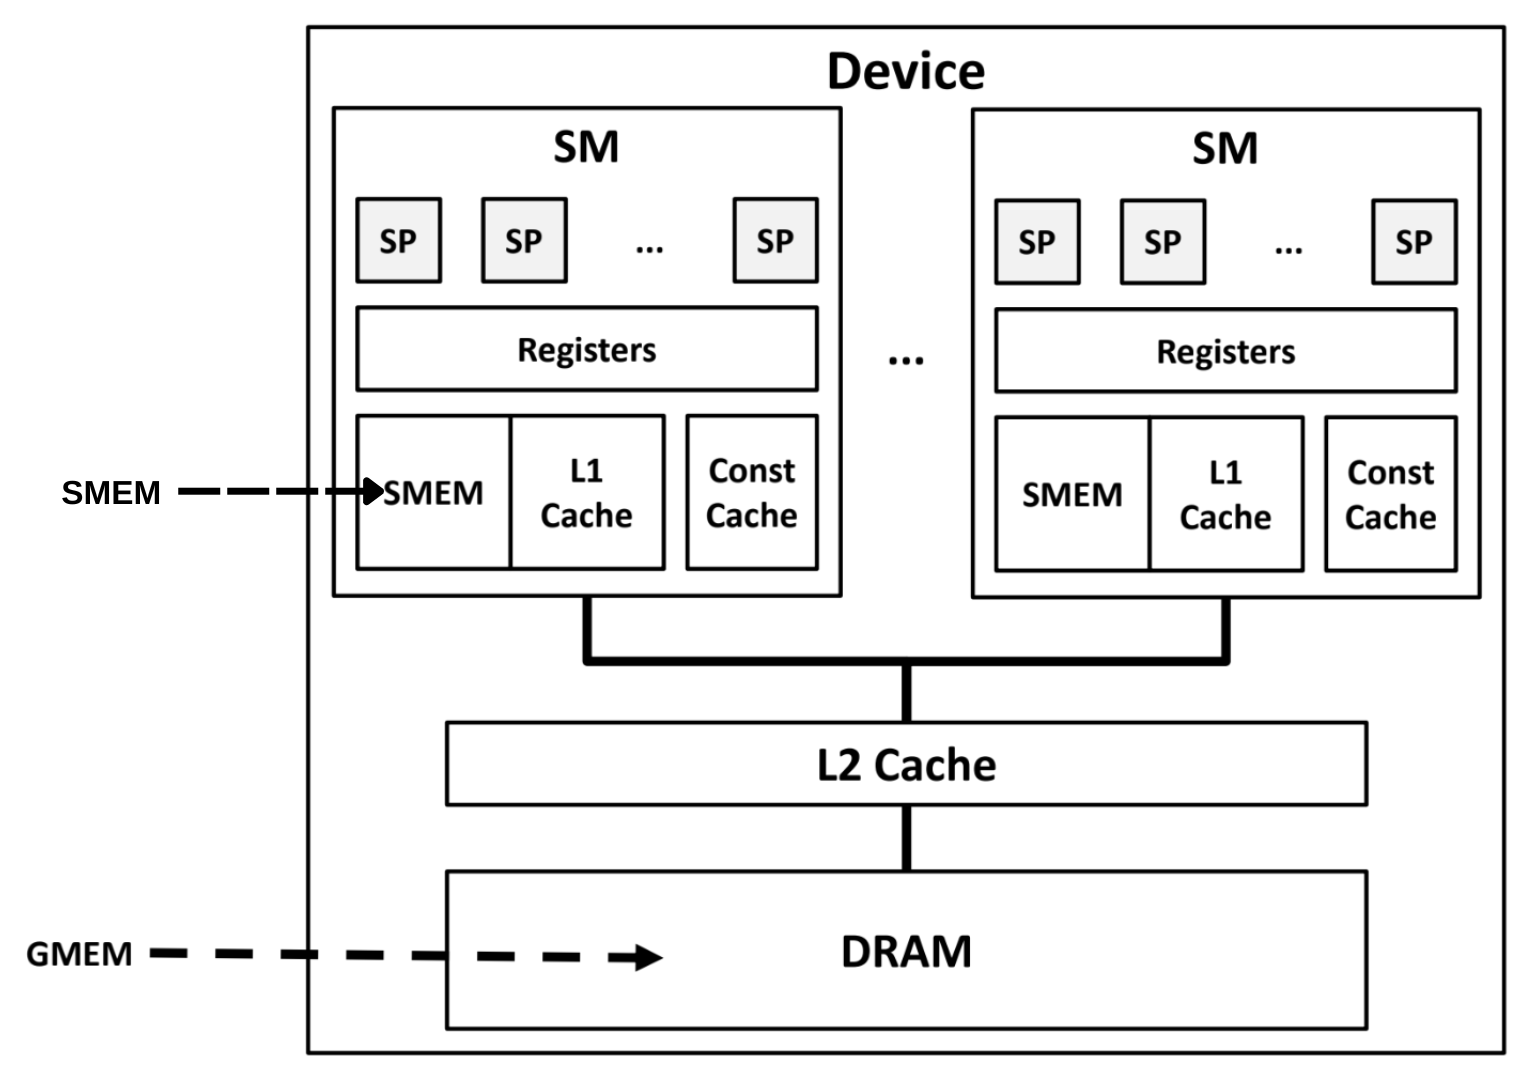

Each block will read its data from **GMEM into SMEM**, then this data in SMEM will be reused many times for threads in the block.

Matrix data in SMEM of each block is **dynamically allocated** to allow the size of the matrix varying with `FILTER_WIDTH` and `blockSize`:
- In the kernel function, declare the array `s_inPixels` in SMEM as follows:

    `extern __shared__ uint8 s_inPixels[];`

- When calling the kernel, in the `<<<...>>>` pair, in addition to the `gridSize` and `blockSize` parameters, it will be passed in a third parameter indicating the size (bytes) of the `s_inPixels` array in each block's SMEM (this size is calculated according to the `FILTER_WIDTH` variable and the `blockSize` variable:

    `size_t s_inPixelsSize = (blockSize.x + FILTER_WIDTH - 1) * (blockSize.y + FILTER_WIDTH - 1) * sizeof(uchar3);`

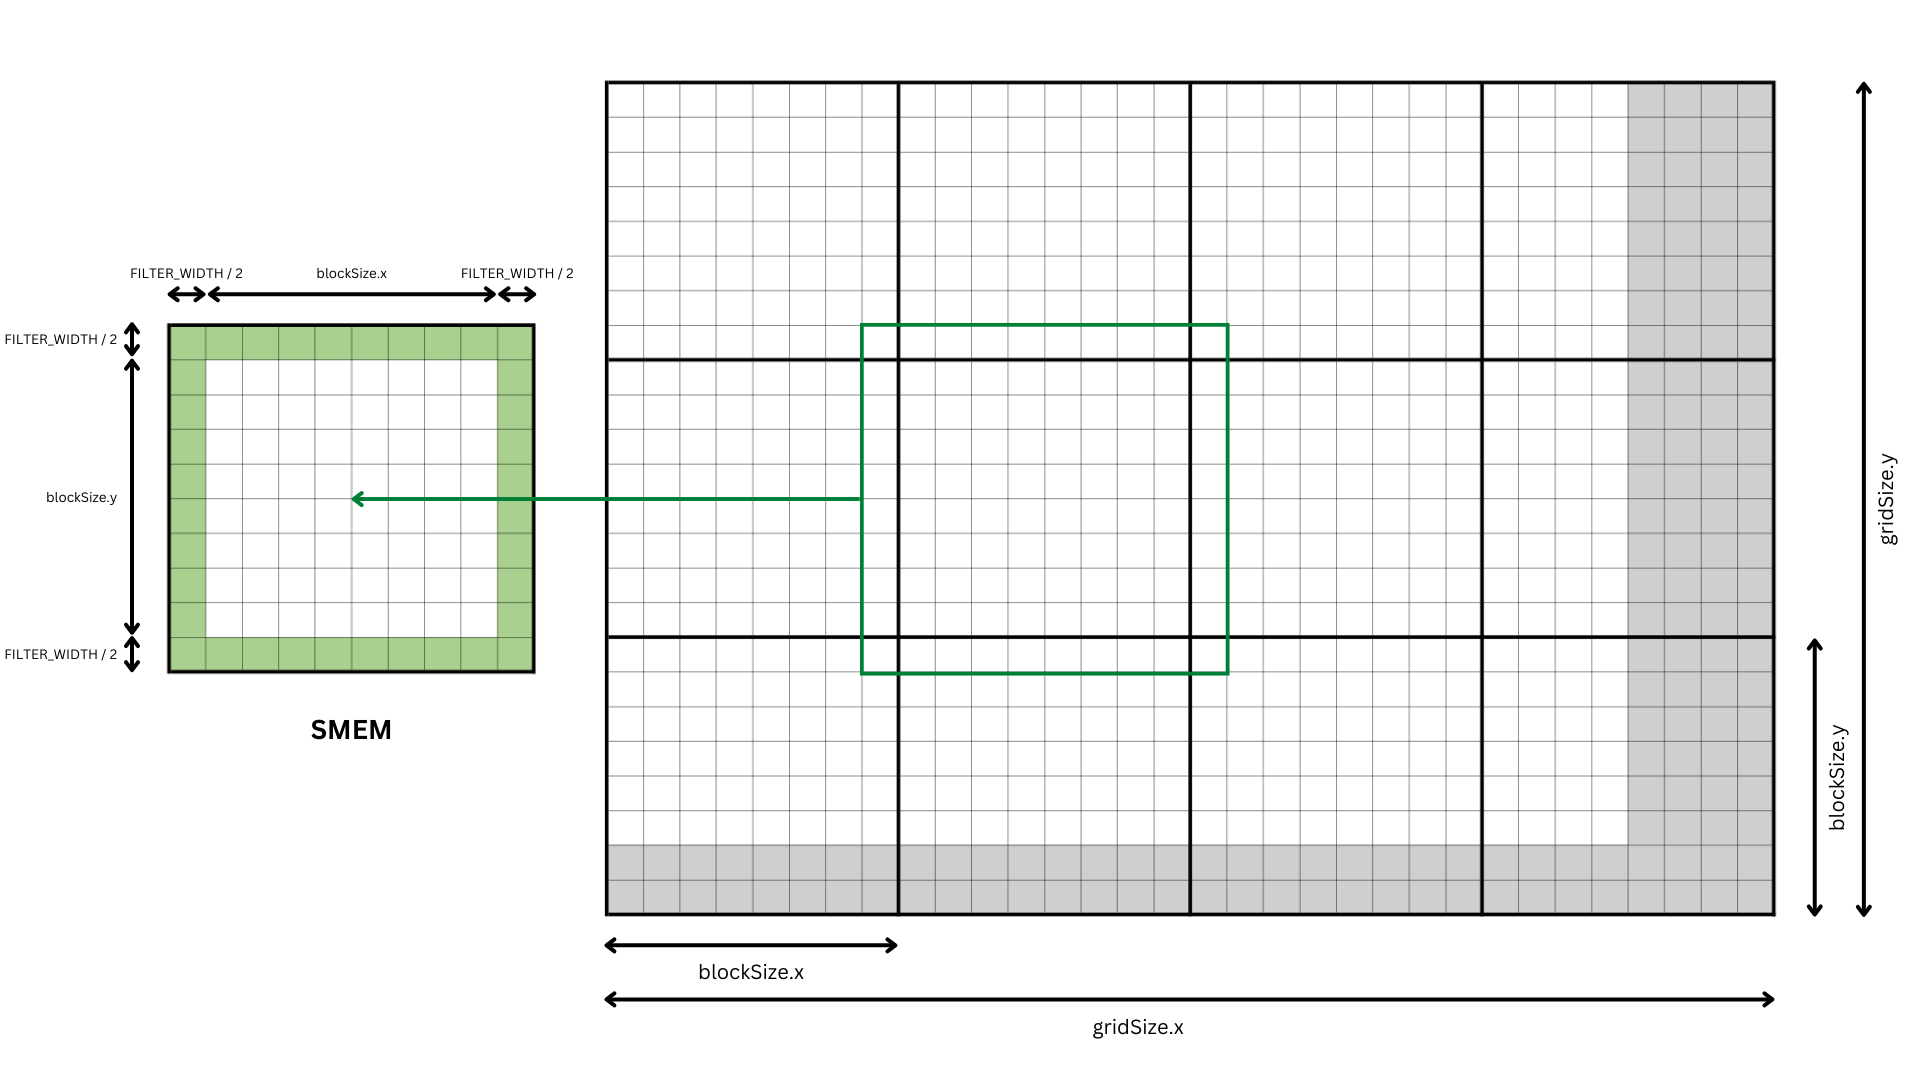

### 4.2.3. Evaluate

*Experiment setup*

Use NVCC Compiler of NVIDIA for compiling.

In [ ]:
!nvcc -arch=sm_{major}{minor} optimize_2.cu -o optimize_2

*Run the code to see results*

Reduce an image

In [ ]:
!./optimize_2 in.pnm out.pnm 300

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1513.781006 ms

Output image size (width x height): 300 x 387



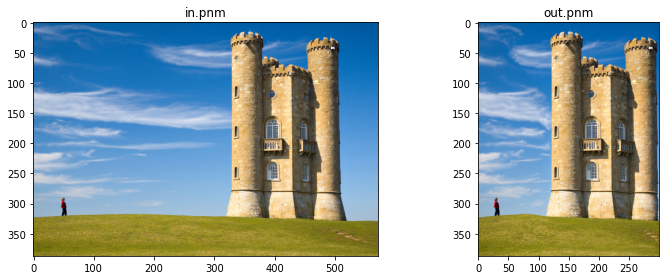

In [ ]:
display_images(['in.pnm', 'out.pnm'], 11, 4)

Enlarge an image

In [ ]:
!./optimize_2 in.pnm out.pnm 800

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1254.942139 ms

Output image size (width x height): 800 x 387



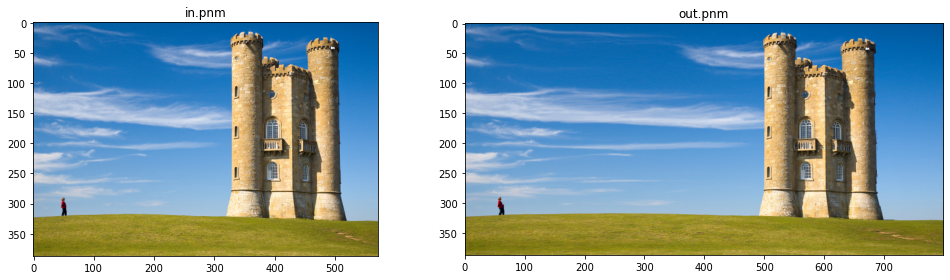

In [ ]:
display_images(['in.pnm', 'out.pnm'], 14, 4)

- The program run **correctly**.
- In all running cells, the procesing time of optimize version always smaller than the procesing time of parallel version and optimize 1 version, thereby the optimization is successful.
- But the processing time has not been significantly improved, are those optimizations enough? Let's experiment more!

## 4.3. Optimization 3

### 4.3.1. Analyze

- Tracing "the least important seam" according to the group's initial analysis is **non-parallelizable**, because the values are completely dependent on many previous values, and the seam is not a simple straight line which is hard for indexing.
- And it's not over yet, finding the index of "the least important seam" before tracing also makes it difficult to parallelize, when this is not simply a problem of finding the minimum value, but finding the position containing the minimum element. It would need a **conditional statement** and an **assign statement**. Assume **assign statement** is guaranteed with `atomicMin()`, but there is no guarantee of any variable assigning between the **conditional statement** and the `atomicMin()` statement.
- But that doesn't stop us from experimenting. Let's try to implement a naive-parallelize version `findLeastImportantSeamKernel` function.

### 4.3.2. Design

- Let each thread compute one element on a row of the seam array - which represents the column position of the seam at each row.

- Each thread find the beginning index of the least important seam, the trace that index to the row handled by that thread.

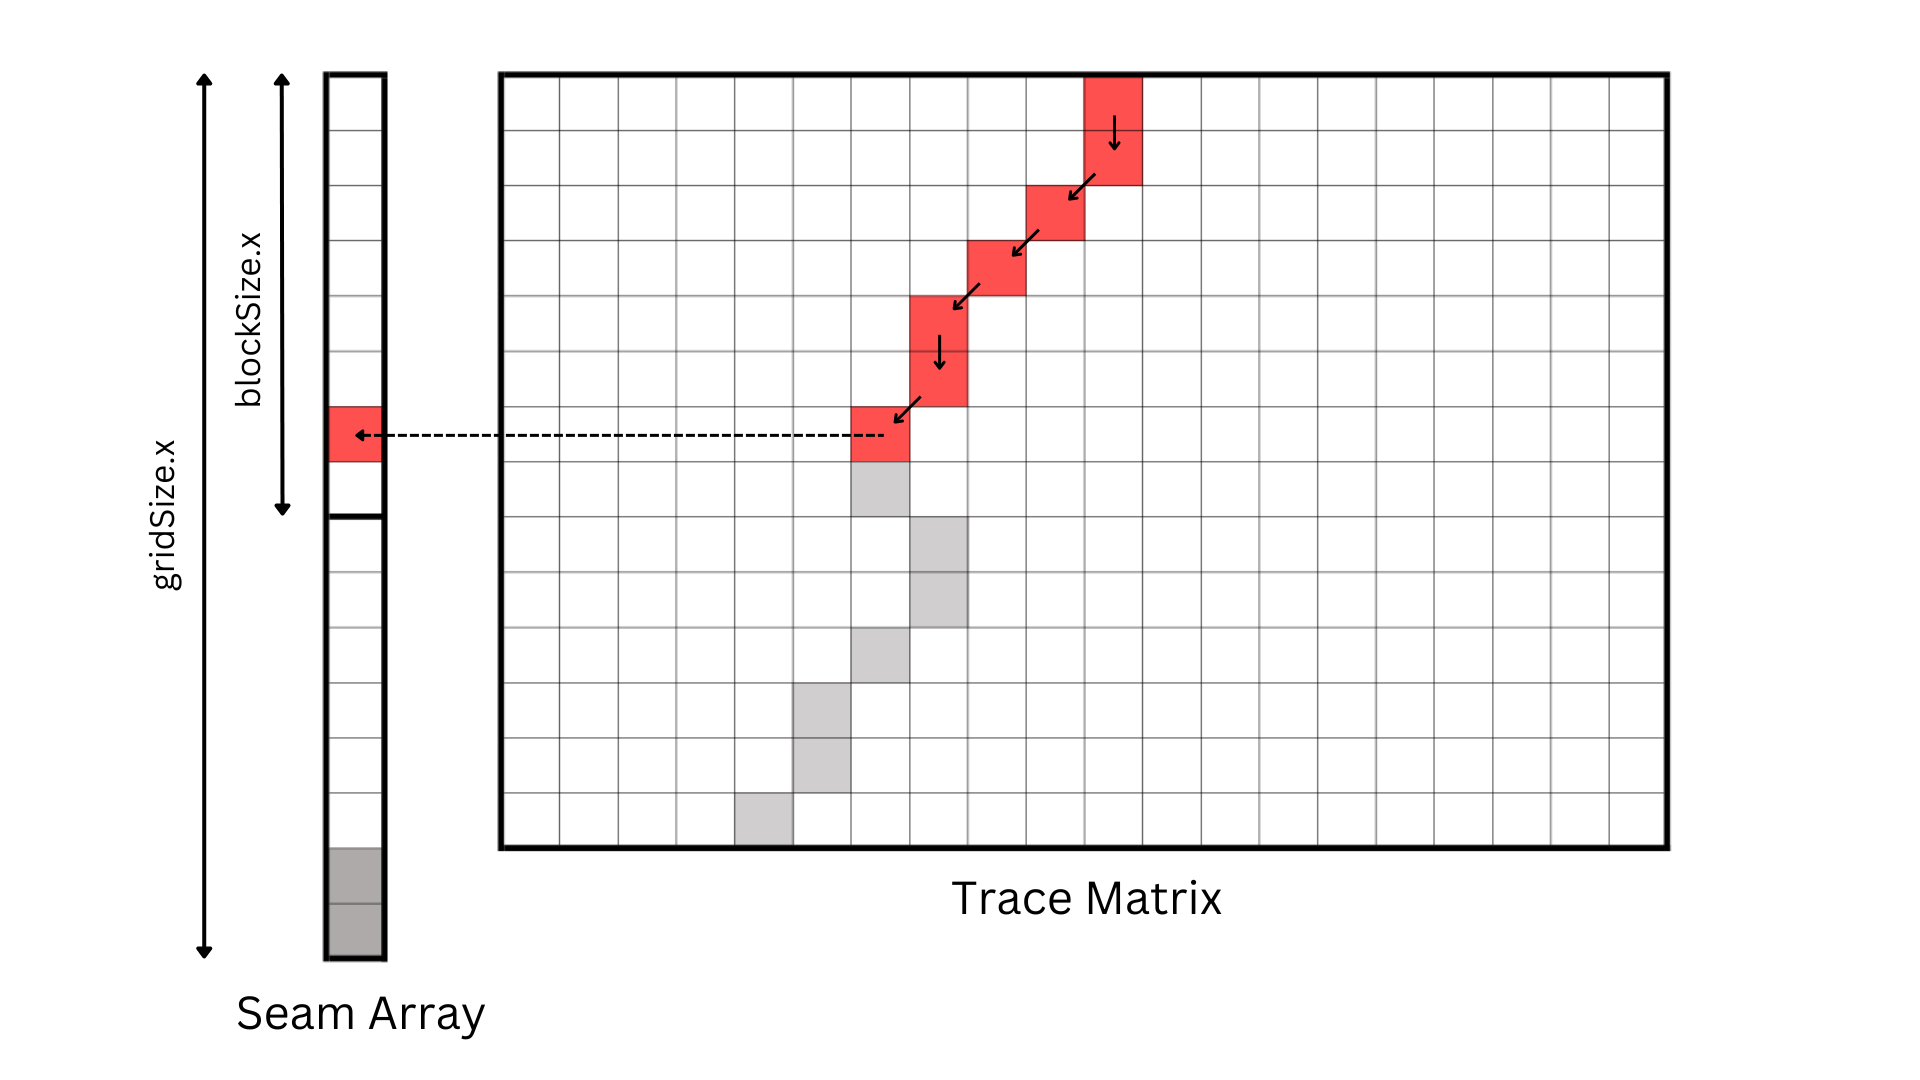

### 4.3.3. Evaluate

*Experiment setup*

Use NVCC Compiler of NVIDIA for compiling.

In [ ]:
!nvcc -arch=sm_{major}{minor} optimize_3.cu -o optimize_3

*Run the code to see results*

Reduce an image

In [ ]:
!./optimize_3 in.pnm out.pnm 300

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1198.032837 ms

Output image size (width x height): 300 x 387



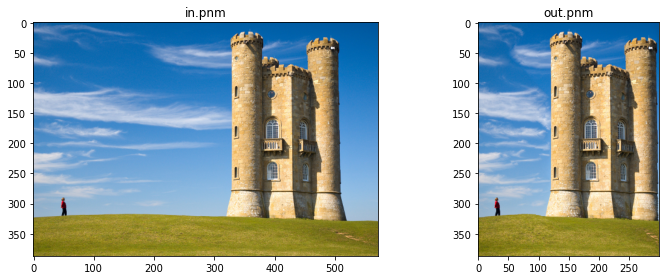

In [ ]:
display_images(['in.pnm', 'out.pnm'], 11, 4)

Enlarge an image

In [ ]:
!./optimize_3 in.pnm out.pnm 800

GPU name: Tesla T4
GPU compute capability: 7.5

Input image size (width x height): 571 x 387

Processing time: 1003.557251 ms

Output image size (width x height): 800 x 387



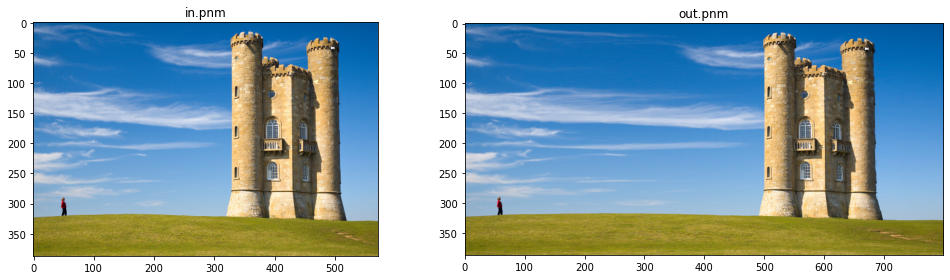

In [ ]:
display_images(['in.pnm', 'out.pnm'], 14, 4)

- The program run **correctly**.
- This is a **pretty extremely special** optimization: the old optimizations only made the program a few milliseconds faster, while this version made the program a hundred milliseconds faster! **This was beyond our initial expectations**.
- This may seem hard to believe, but it's actually understandable: This version eliminates the copying of the `L` and `T` matrices from the device to the host processing, and also eliminates the copying of the matrix `seam` from host to device processing.

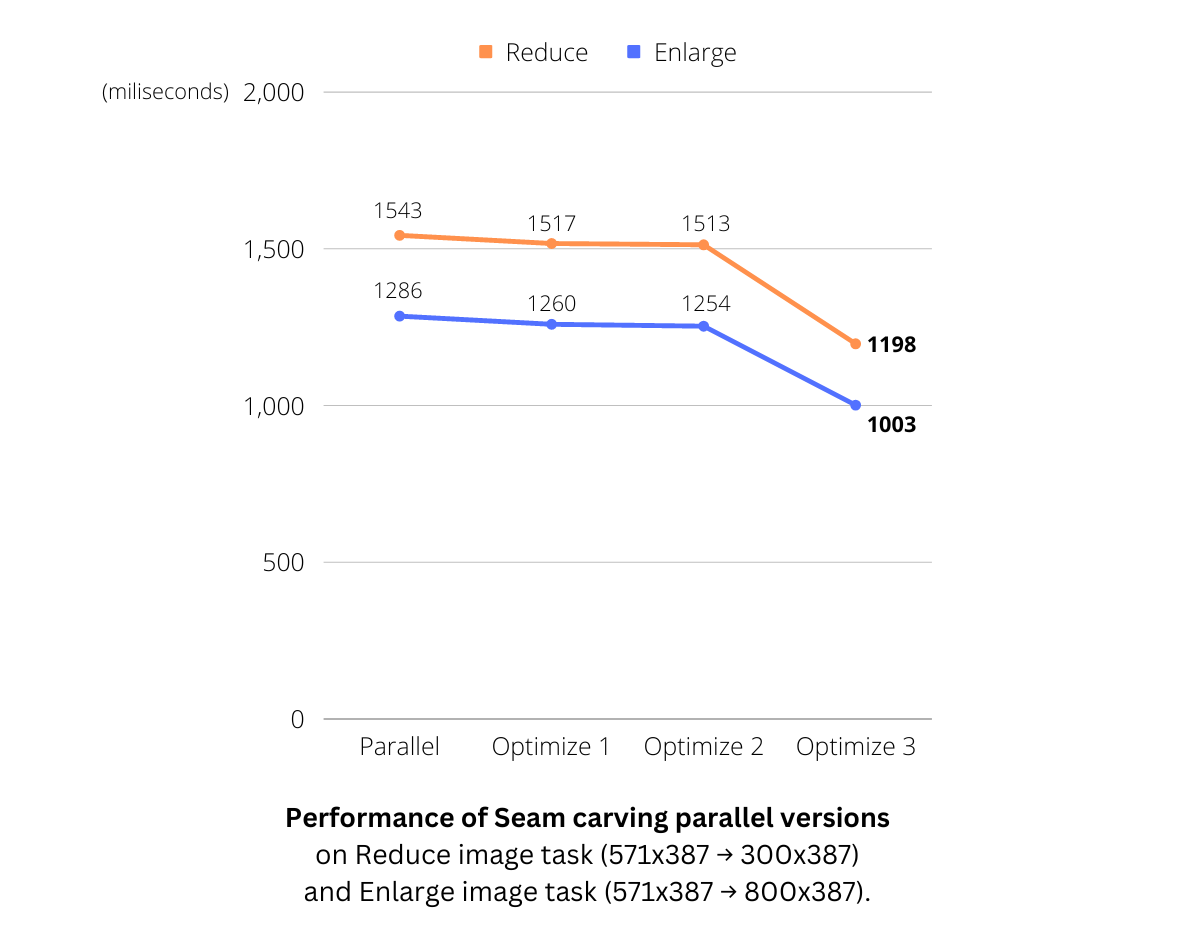

# 5. Reflection

## 5.1. What difficulties have we encountered?

**Nguyễn Thanh Tình**
- I had no difficulty doing this project. It was easy.


**Trương Quang Minh Nhật**
- Difficulty in understanding of the duplicate method.
- Difficulty in implement parallelize version.

**Võ Xuân Thiên**
- Difficulty in implement parallelize version.
- Difficulty in making the program running faster.

## 5.2. What have we learned?

**Nguyễn Thanh Tình**
- Learn how to parallelize a algorithm.
- Learn the program optimization process.
- Understand what is Seam Carving algorithm.
- Access DRAM efficiently.
- Revise some important kernels for parallel programming.

**Trương Quang Minh Nhật**
- How to apply kernel for image using convolution.
- Processing image using parallel method with CUDA.
- Understanding Seam Carving method.
- Team work.

**Võ Xuân Thiên**
- Working with a picture using prallel programming.
- How to apply parallel to a problem.
- Optimization a parallel programing.
- Understand seam carving method.

## 5.3. Future work

**Height Resizing**

Stick to the **requirements of the project**: "*resize image with smaller/larger width, same height*", we implemented Width Resizing by Seam Carving algorithm.

But it's not difficult to implement Height Resizing version, here are two ways we recommend:
- Calculate Energy Map and trace horizontally.
- Rotate image 90°, then apply Width Resizing on it.

**Multiple Resizing**

By combining Width Resizing and Height Resizing, it is easy to get a Multiple Resizing version.

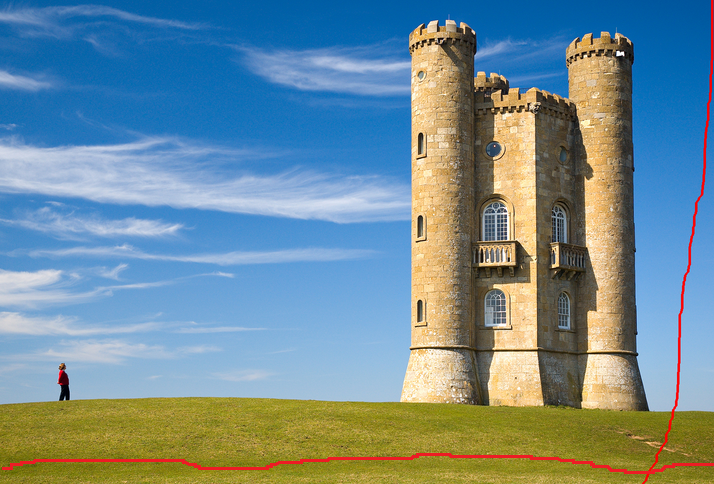

**Triangular-blocked strips: A specific algorithm for parallelizing the Seam Carving algorithm**

- The version we implemented above is also called **Row-major order**: firstly we calculate all the elements on the last row, then the above row of the last row, and so on. With this ordering, the values in a row can be calculated completely in parallel, because each elêmnt depends only on the three values from the bottom row that have been calculated.

- A problem with that algorithm is that a typical image is only a few thousand pixels wide at most, and each pixel requires only a small amount of work. That's not enough work (per row) for efficient parallelization!

We did some research and were impressed with the algorithm called **Triangular-blocked strips**.
- First, it is easy to see that every element $L[i, j]$ in the energy matrix is **built from a triangle** whose vertex is the point $[i, j]$, and the base is also the base of the $Importance$ matrix.
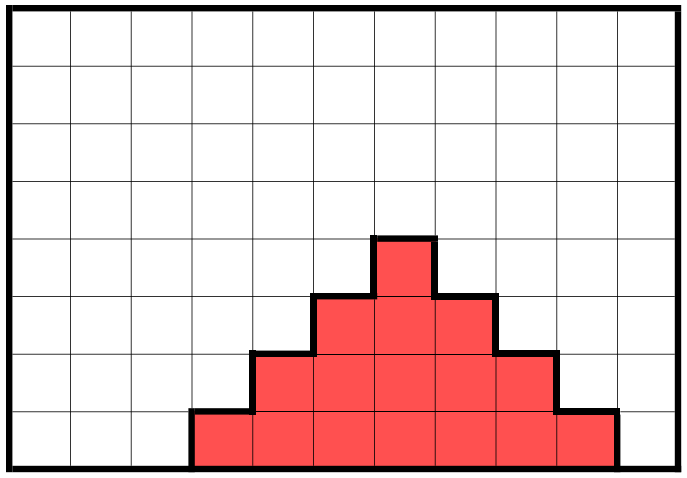

- We can use triangles like this for parallelization. First, group adjacent rows into **strips**. In each **strip**, cover the top of the strip with a downward-facing triangular. The remaining space will look like a series of upward triangles. Then, process each strip with two parallel loops, one for processing the downward triangles in parallel, the other for processing the upward triangles.
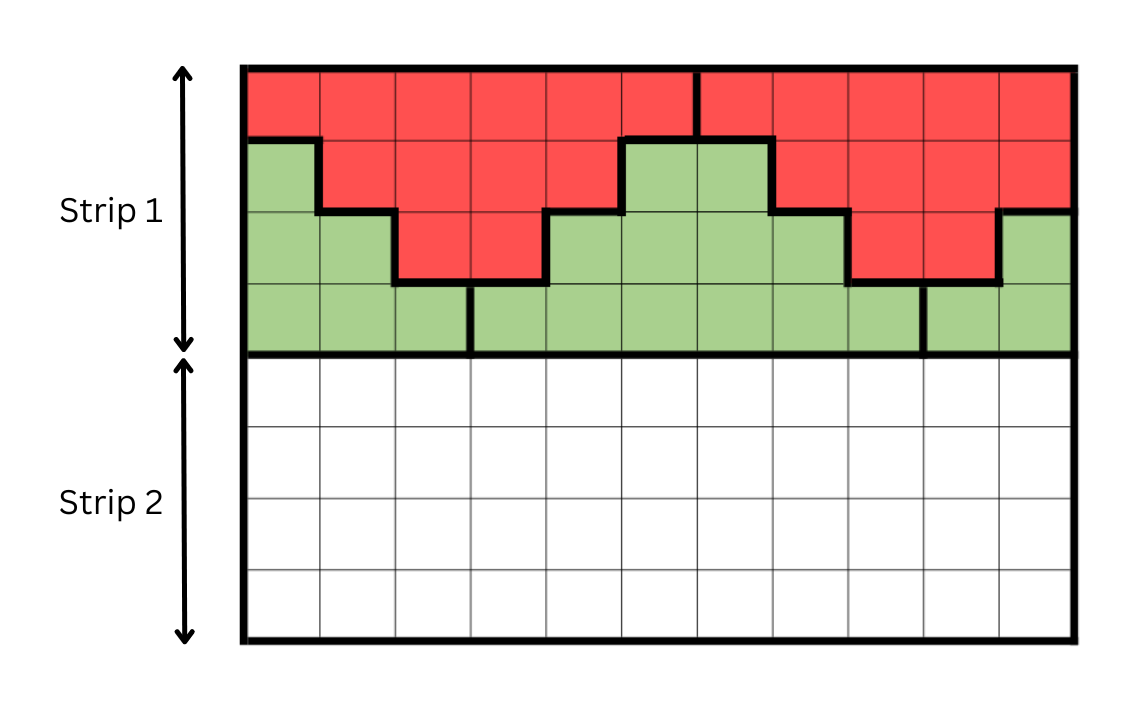

**Object removal**

Seam Carving algorithm can be used for Object Removal. As the example in the picture below, the user marks a region for removal (green), and possibly a region to protect (red), on the original image - left image. On the right image, consecutive vertical seam were removed until no ‘green’ pixels were left.

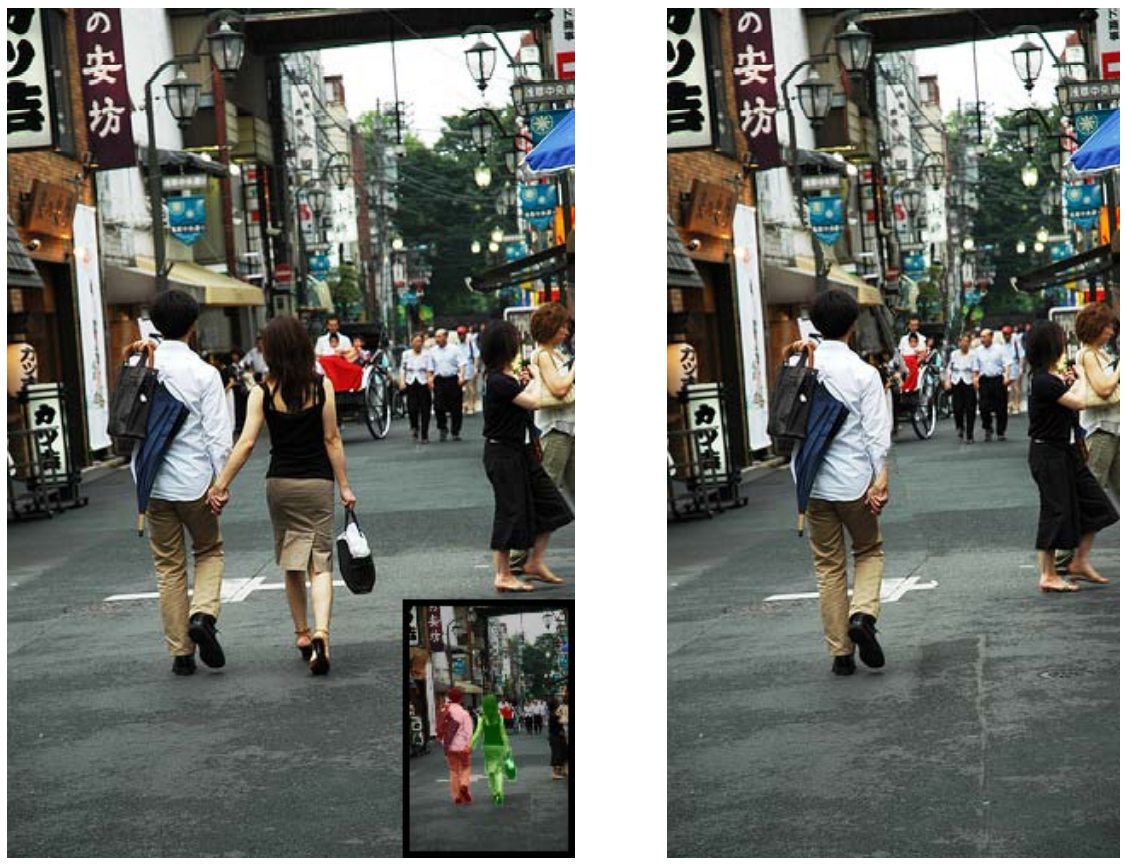

*(Source: https://perso.crans.org/frenoy/matlab2012/seamcarving.pdf)*

# 6. References

- M.Sc. Phạm Trọng Nghĩa, Course materials, 2022
- M.Sc. Phạm Trọng Nghĩa, Code demo, 2022
- Seam Carving: https://en.wikipedia.org/wiki/Seam_carving
- Seam Carving - Live Coding Session | MIT 18.S191 Fall 2020 | James Schloss: https://youtu.be/ALcohd1q3dk
- Shai Avidan, Ariel Shamir, Seam Carving for Content-Aware Image Resizing:
https://perso.crans.org/frenoy/matlab2012/seamcarving.pdf
- Parallel Seam Carving, Triangular-blocked strips: https://shwestrick.github.io/2020/07/29/seam-carve.html

Thank you for reading this notebook.